In [ ]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from functools import partial
from tensorflow.keras.applications.vgg16 import VGG16
import glob
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns
import visualkeras
from sklearn.metrics import roc_auc_score

2023-04-28 12:43:05.956829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Downloading the images:

In [3]:
dataset_path = '/Users/George_1/PycharmProjects/ML3/funny.csv'
data = pd.read_csv(dataset_path)



def download_image(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(io.BytesIO(response.content))
        return img
    except:
        return None


images = []
scores = []

for index, row in data.iterrows():
    url = row['url']
    score = row['score']
    img = download_image(url)

    if img is not None:
        images.append(img)
        scores.append(score)


Making Validation, Training, and Test sets:

In [4]:
input_size = (128, 128)
X = np.array([np.array(img.convert('RGB').resize(input_size[:2])) for img in images])
y = np.array([1 if score > 100 else 0 for score in scores])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
num_zeros = np.count_nonzero(y_val == 0)
num_ones = np.count_nonzero(y_val == 1)

# Print the counts
print("Number of 0's: ", num_zeros)
print("Number of 1's: ", num_ones)

Number of 0's:  72
Number of 1's:  44


Asteíos Model's Birth:

In [8]:
input_shape = (128, 128, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = Flatten()(x)
x = Dense(320, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(125, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create a separate model that includes the base_model and additional layers
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# define the data generator for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    rescale=1./128.
)

# train the base model and save its weights
batch_size = 32
epochs = 10
steps_per_epoch = len(X_train) // batch_size
print("Starting training...")
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    verbose=1 )
# calculate the number of augmented data used to train the model
total_augmented_samples = epochs * steps_per_epoch * batch_size
print("Estimated total number of augmented samples produced:", total_augmented_samples)

model.save('FINAL10.h5')

# define a list of models to ensemble
models = []
histories = []
for i in range(5):
    model = keras.models.load_model('FINAL10.h5')
    datagen_i = ImageDataGenerator(
        rotation_range=20 + i*5,  # increase rotation range for each model
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect',
        rescale=1./128.
    )
    num_augmented_images = 0
    for X_batch, y_batch in datagen_i.flow(X_train, y_train, batch_size=batch_size):
        num_augmented_images += X_batch.shape[0]
        if num_augmented_images >= len(X_train):
            break

    print(f"Training model {i+1} with {num_augmented_images} augmented images...")


# train the model with the augmented data and save its weights
    history = model.fit(datagen_i.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    verbose=1 )
    model.save_weights(f'final_model_10_{i}_weights.h5')
    models.append(model)
    histories.append(history)
# make predictions with the ensemble
ensemble_predictions = []
for model in models:
    preds = model.predict(X_test)
    ensemble_predictions.append(preds)
ensemble_predictions = np.mean(ensemble_predictions, axis=0)

2023-04-24 12:38:56.530624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-24 12:38:56.531895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Starting training...
Epoch 1/10


2023-04-24 12:38:58.344085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-24 12:39:00.397110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.6306

2023-04-24 12:39:26.011381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 29s 2s/step - loss: 0.6897 - accuracy: 0.6306 - val_loss: 1.5845 - val_accuracy: 0.5431
Epoch 2/10
10/10 [==============================] - 19s 2s/step - loss: 0.6425 - accuracy: 0.6433 - val_loss: 9.2529 - val_accuracy: 0.6207
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.6553 - accuracy: 0.6783 - val_loss: 6.7675 - val_accuracy: 0.6207
Epoch 4/10
10/10 [==============================] - 17s 2s/step - loss: 0.6345 - accuracy: 0.7006 - val_loss: 0.9656 - val_accuracy: 0.6121
Epoch 5/10
10/10 [==============================] - 16s 2s/step - loss: 0.6338 - accuracy: 0.6783 - val_loss: 1.9919 - val_accuracy: 0.6207
Epoch 6/10
10/10 [==============================] - 15s 2s/step - loss: 0.6283 - accuracy: 0.6783 - val_loss: 0.9197 - val_accuracy: 0.6207
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: 0.6109 - accuracy: 0.7038 - val_loss: 0.8502 - val_accuracy: 0.6207
Epoch 8/10
10/10 [=============

2023-04-24 12:42:17.250003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-24 12:42:18.779566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.7038

2023-04-24 12:42:40.701476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 25s 2s/step - loss: 0.6147 - accuracy: 0.7038 - val_loss: 1.0914 - val_accuracy: 0.6207
Epoch 2/10
10/10 [==============================] - 16s 2s/step - loss: 0.6059 - accuracy: 0.6975 - val_loss: 0.7948 - val_accuracy: 0.6207
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: 0.6237 - accuracy: 0.6719 - val_loss: 1.1966 - val_accuracy: 0.6207
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 0.6158 - accuracy: 0.7006 - val_loss: 1.3590 - val_accuracy: 0.6207
Epoch 5/10
10/10 [==============================] - 21s 2s/step - loss: 0.6078 - accuracy: 0.6911 - val_loss: 1.0078 - val_accuracy: 0.6207
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.5912 - accuracy: 0.7038 - val_loss: 0.7191 - val_accuracy: 0.6207
Epoch 7/10
10/10 [==============================] - 19s 2s/step - loss: 0.6134 - accuracy: 0.6783 - val_loss: 0.8119 - val_accuracy: 0.6207
Epoch 8/10
10/10 [=============

2023-04-24 12:45:41.050889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-24 12:45:41.926776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.6847

2023-04-24 12:46:06.909580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 28s 2s/step - loss: 0.6170 - accuracy: 0.6847 - val_loss: 0.9615 - val_accuracy: 0.6207
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.6163 - accuracy: 0.6911 - val_loss: 1.2841 - val_accuracy: 0.6121
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.6424 - accuracy: 0.6752 - val_loss: 1.9629 - val_accuracy: 0.6207
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.6199 - accuracy: 0.6911 - val_loss: 1.9587 - val_accuracy: 0.6207
Epoch 5/10
10/10 [==============================] - 21s 2s/step - loss: 0.6073 - accuracy: 0.7006 - val_loss: 1.2051 - val_accuracy: 0.6207
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.6257 - accuracy: 0.6879 - val_loss: 1.3555 - val_accuracy: 0.6207
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.6147 - accuracy: 0.6943 - val_loss: 2.9488 - val_accuracy: 0.6207
Epoch 8/10
10/10 [=============

2023-04-24 12:49:13.445707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-24 12:49:14.323463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.6911

2023-04-24 12:49:37.984398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 27s 2s/step - loss: 0.6119 - accuracy: 0.6911 - val_loss: 0.9688 - val_accuracy: 0.6207
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 0.6170 - accuracy: 0.6911 - val_loss: 1.0456 - val_accuracy: 0.6207
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: 0.6125 - accuracy: 0.6938 - val_loss: 1.5717 - val_accuracy: 0.6207
Epoch 4/10
10/10 [==============================] - 15s 2s/step - loss: 0.6164 - accuracy: 0.7006 - val_loss: 1.8512 - val_accuracy: 0.6207
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.6116 - accuracy: 0.6911 - val_loss: 1.6564 - val_accuracy: 0.6207
Epoch 6/10
10/10 [==============================] - 17s 2s/step - loss: 0.6303 - accuracy: 0.6938 - val_loss: 0.8229 - val_accuracy: 0.6207
Epoch 7/10
10/10 [==============================] - 19s 2s/step - loss: 0.6255 - accuracy: 0.6847 - val_loss: 1.2798 - val_accuracy: 0.6207
Epoch 8/10
10/10 [=============

2023-04-24 12:52:22.199599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-24 12:52:23.096364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.7006

2023-04-24 12:52:48.067440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 28s 2s/step - loss: 0.6194 - accuracy: 0.7006 - val_loss: 0.6867 - val_accuracy: 0.6207
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.6255 - accuracy: 0.6943 - val_loss: 1.0129 - val_accuracy: 0.6207
Epoch 3/10
10/10 [==============================] - 23s 2s/step - loss: 0.6228 - accuracy: 0.6943 - val_loss: 9.0285 - val_accuracy: 0.6207
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.6247 - accuracy: 0.7006 - val_loss: 1.5856 - val_accuracy: 0.6207
Epoch 5/10
10/10 [==============================] - 20s 2s/step - loss: 0.6068 - accuracy: 0.7006 - val_loss: 0.8666 - val_accuracy: 0.6207
Epoch 6/10
10/10 [==============================] - 19s 2s/step - loss: 0.6245 - accuracy: 0.6847 - val_loss: 0.8132 - val_accuracy: 0.6207
Epoch 7/10
10/10 [==============================] - 18s 2s/step - loss: 0.6199 - accuracy: 0.6847 - val_loss: 0.7725 - val_accuracy: 0.6207
Epoch 8/10
10/10 [=============

2023-04-24 12:55:50.909677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-24 12:55:51.933776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.6844

2023-04-24 12:56:22.155362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 34s 3s/step - loss: 0.6339 - accuracy: 0.6844 - val_loss: 0.8350 - val_accuracy: 0.6207
Epoch 2/10
10/10 [==============================] - 19s 2s/step - loss: 0.6208 - accuracy: 0.7006 - val_loss: 1.8781 - val_accuracy: 0.6207
Epoch 3/10
10/10 [==============================] - 22s 2s/step - loss: 0.6339 - accuracy: 0.6752 - val_loss: 1.6172 - val_accuracy: 0.6207
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.6221 - accuracy: 0.7038 - val_loss: 1.4869 - val_accuracy: 0.6207
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.6269 - accuracy: 0.6879 - val_loss: 0.8004 - val_accuracy: 0.6121
Epoch 6/10
10/10 [==============================] - 15s 1s/step - loss: 0.6097 - accuracy: 0.7038 - val_loss: 0.6584 - val_accuracy: 0.6379
Epoch 7/10
10/10 [==============================] - 15s 1s/step - loss: 0.6080 - accuracy: 0.7102 - val_loss: 0.6585 - val_accuracy: 0.5862
Epoch 8/10
10/10 [=============

2023-04-24 12:58:55.668706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 321ms/step


2023-04-24 12:58:57.584152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 499ms/step


2023-04-24 12:58:59.983868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 435ms/step


2023-04-24 12:59:02.156360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 389ms/step


2023-04-24 12:59:04.158302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 402ms/step


In [5]:
# convert predictions to binary labels (0 or 1)
ensemble_labels = np.round(ensemble_predictions)

# calculate accuracy
accuracy = accuracy_score(y_test, ensemble_labels)
print('Ensemble accuracy:', accuracy)

Ensemble accuracy: 0.6752136752136753


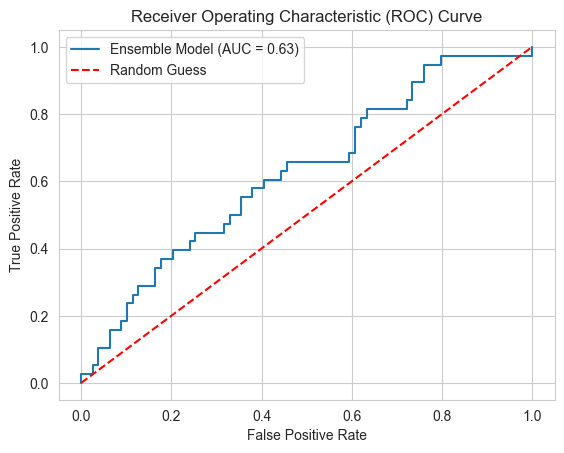

In [6]:
fpr2, tpr2, thresholds = roc_curve(y_test, ensemble_predictions)
auc_score = roc_auc_score(y_test, ensemble_predictions)
plt.plot(fpr2, tpr2, label='Ensemble Model (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


ROC AUC SCORE:

In [7]:
score = model.evaluate(X_val, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)





score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr1, tpr1)
print('Test ROC AUC:', roc_auc)

4/4 [==============================] - 1s 165ms/step - loss: 1.5667 - accuracy: 0.5812

Validation loss / accuracy: 1.5667 / 0.5812
4/4 [==============================] - 1s 201ms/step
Validation ROC AUC: 0.6116446578631453
4/4 [==============================] - 1s 163ms/step - loss: 1.0294 - accuracy: 0.6752

Test loss / accuracy: 1.0294 / 0.6752
4/4 [==============================] - 1s 167ms/step
Test ROC AUC: 0.6379080612924717


Learning curves of each model:

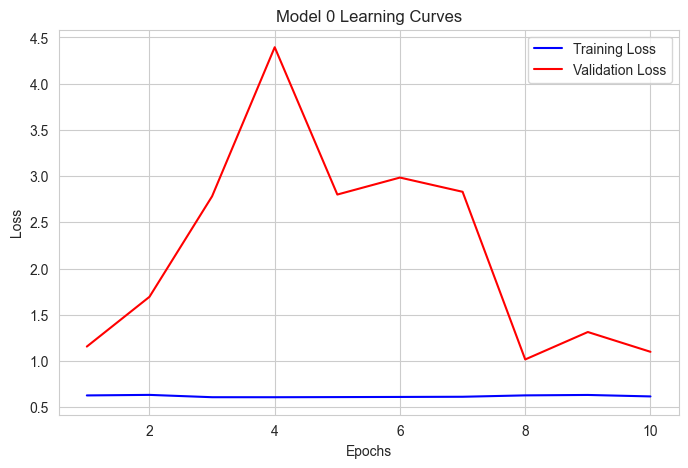

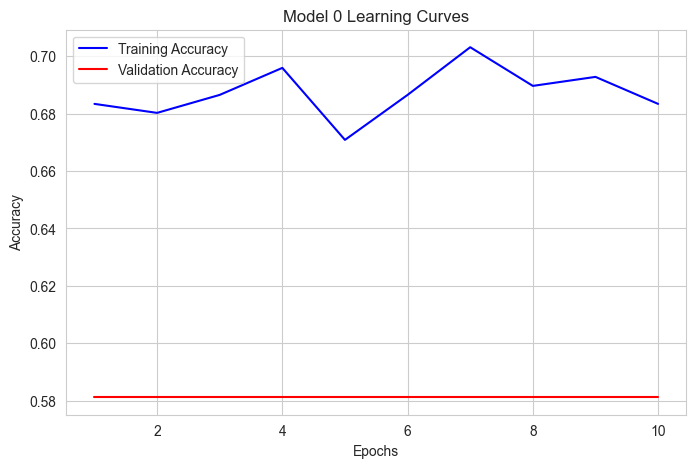

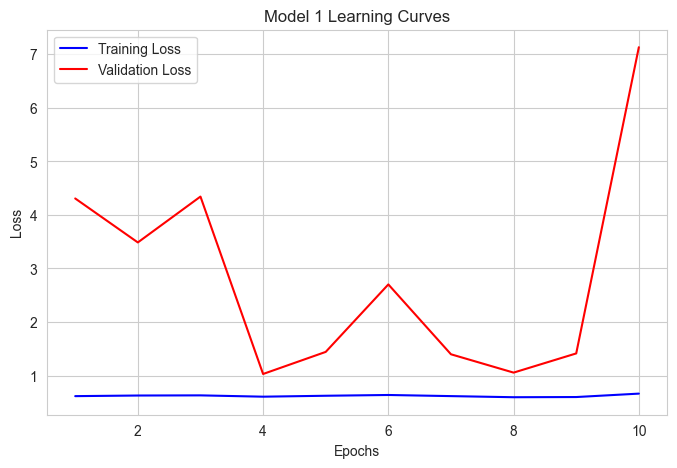

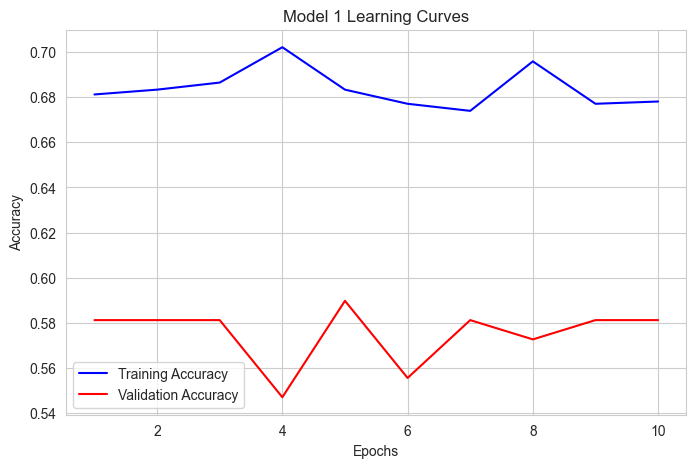

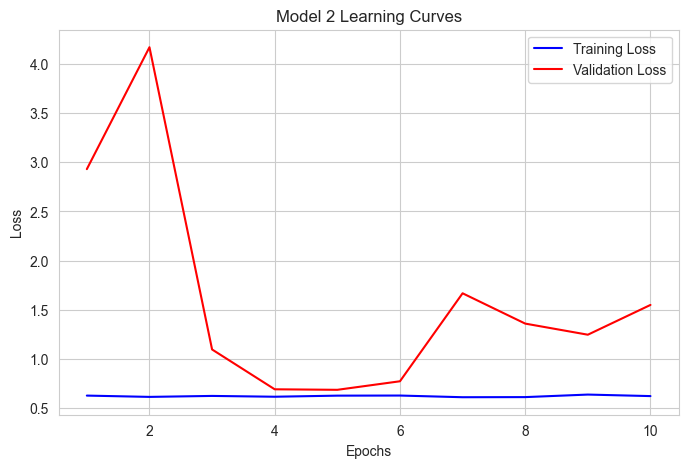

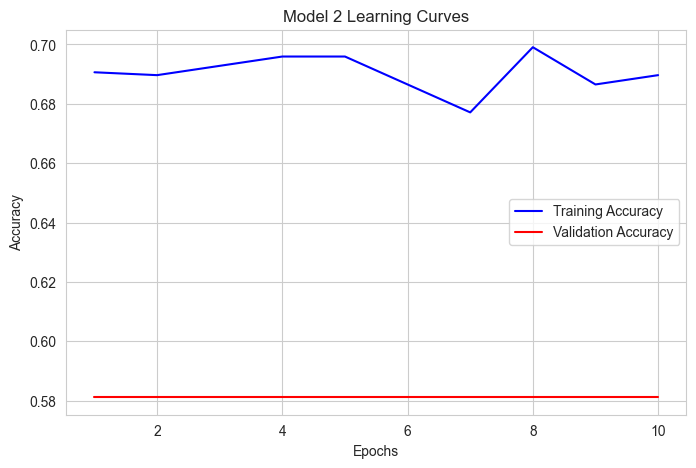

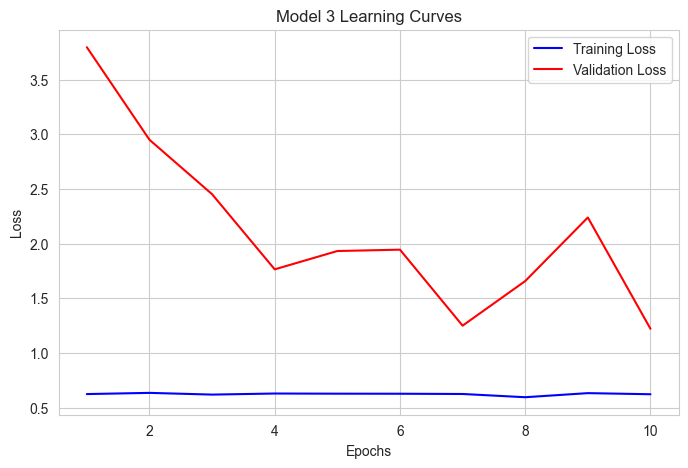

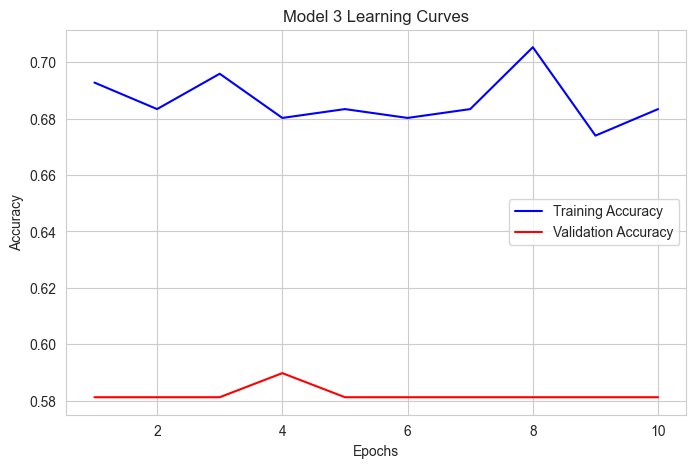

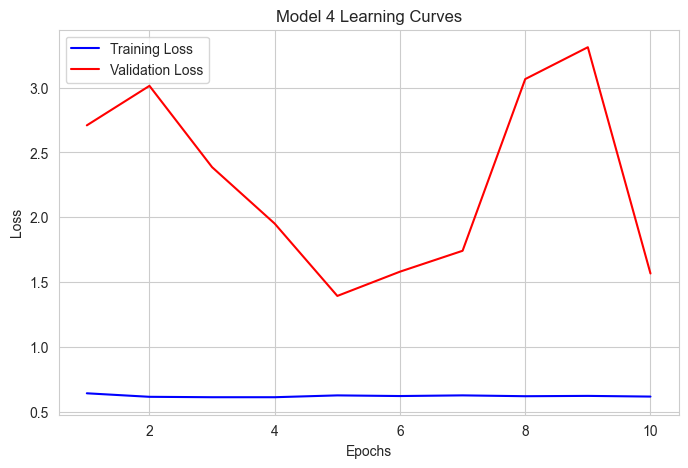

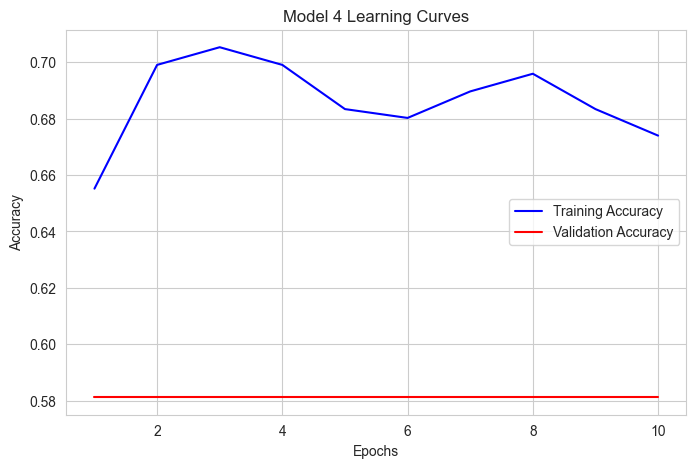

In [8]:
# plot the learning curves for each model
for i, history in enumerate(histories):
    # extract the training and validation loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # plot the training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'Model {i} Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the training and validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'Model {i} Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


ROC CURVE:

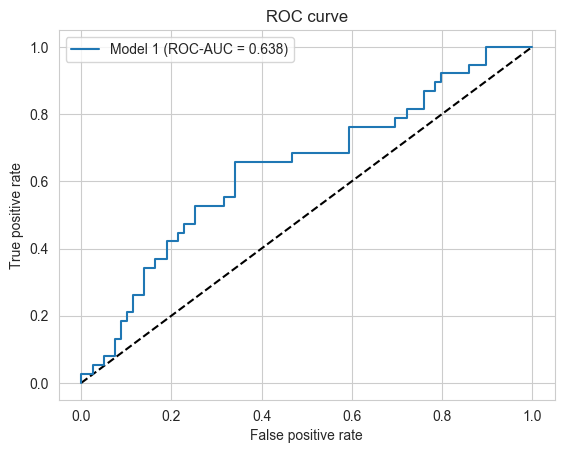

In [9]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr1, tpr1, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

4/4 [==============================] - 1s 236ms/step


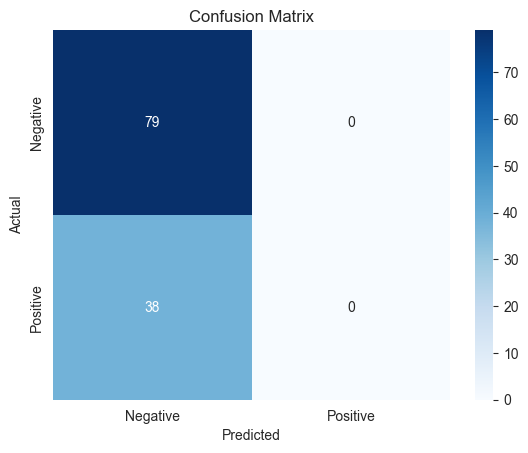

In [10]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'],yticklabels=['Negative', 'Positive'])

# Set plot labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show plot
plt.show()

Sample of Augmented Images:

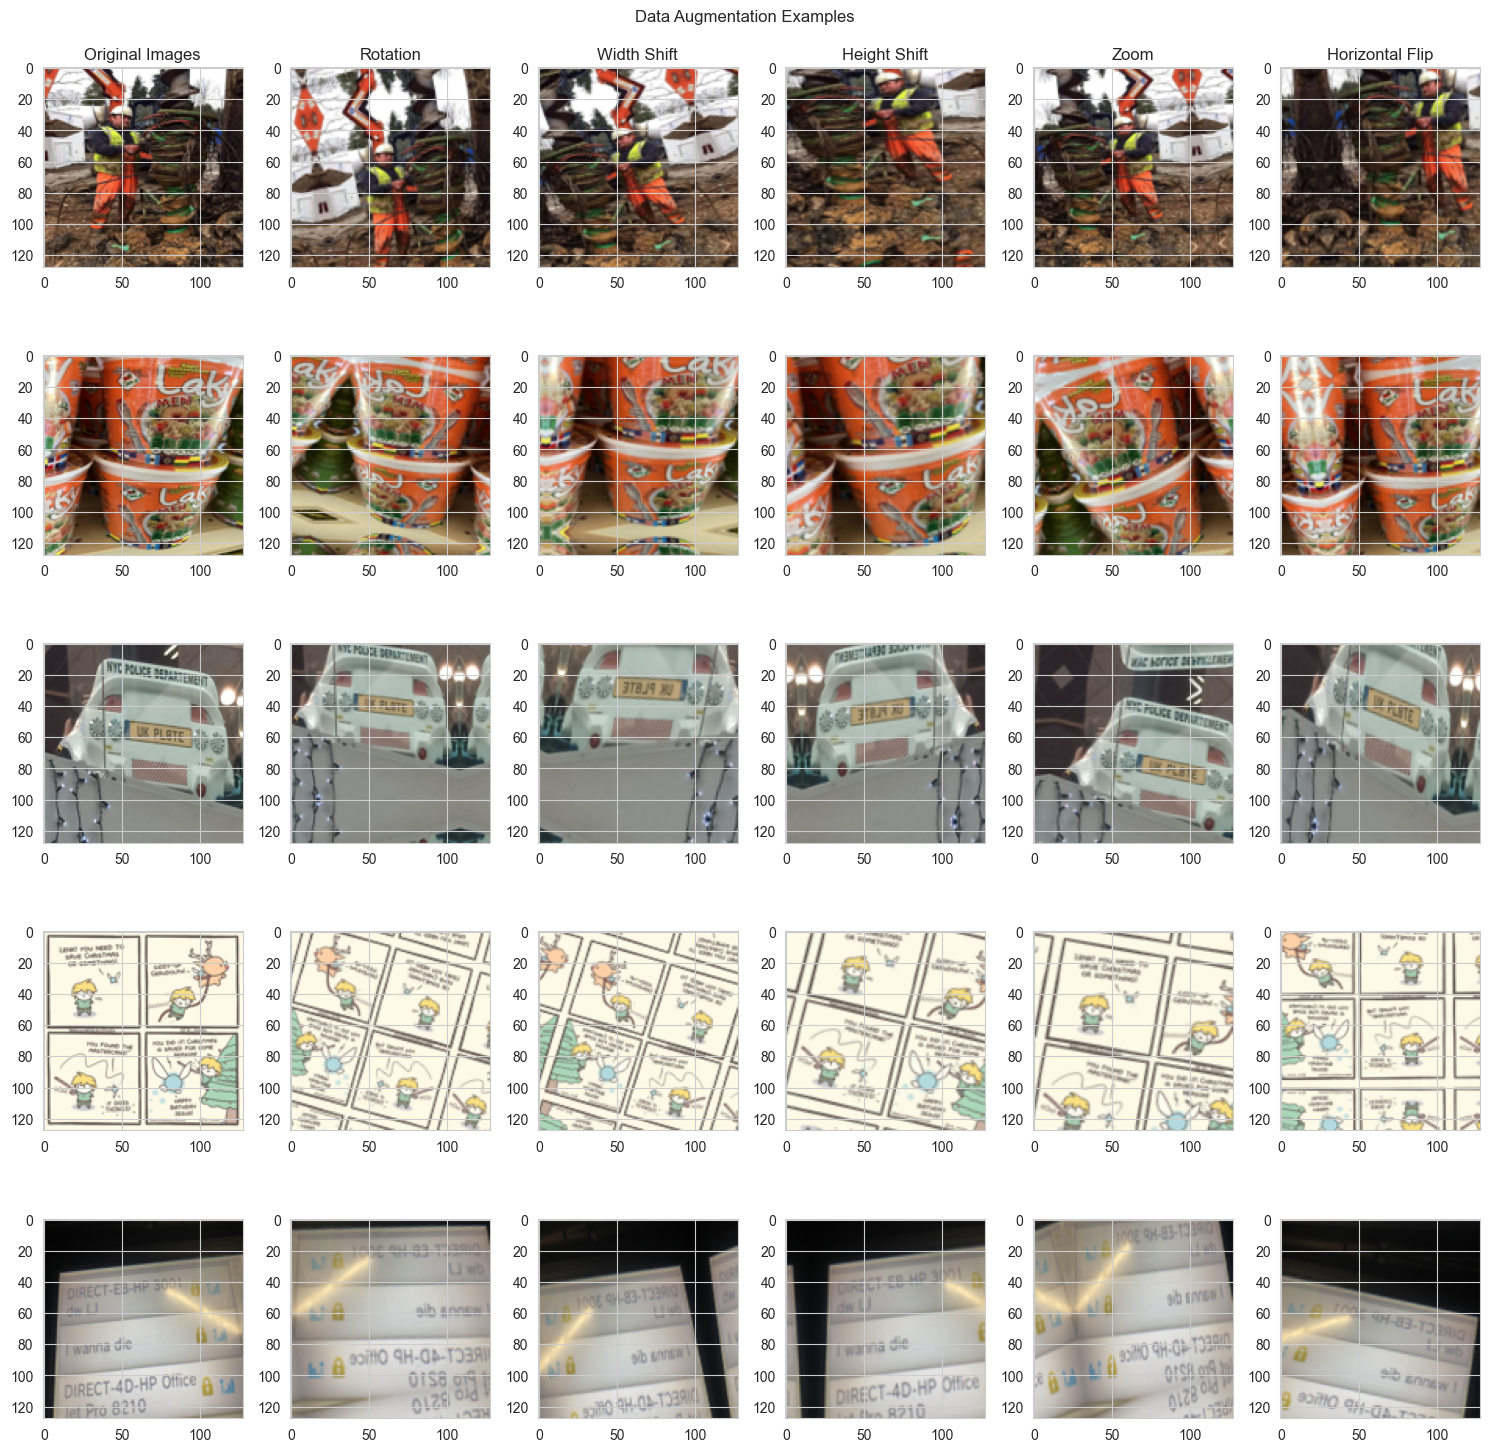

In [11]:
# shuffle the training set
shuffle_indices = np.random.permutation(len(X_train))
X_train_shuffled = X_train[shuffle_indices]

# select the first six images from the shuffled training set
sample_imgs = X_train_shuffled[:6]

# plot the original and augmented images side-by-side
fig, axs = plt.subplots(5, 6, figsize=(15, 15))
fig.suptitle('Data Augmentation Examples')
axs[0, 0].set_title('Original Images')
axs[0, 1].set_title('Rotation')
axs[0, 2].set_title('Width Shift')
axs[0, 3].set_title('Height Shift')
axs[0, 4].set_title('Zoom')
axs[0, 5].set_title('Horizontal Flip')
for i in range(5):
    axs[i, 0].imshow(sample_imgs[i])
    for j in range(1, 6):
        aug_img = datagen.random_transform(sample_imgs[i])
        axs[i, j].imshow(aug_img)

plt.tight_layout()
plt.show()

Cat Image Analysis:

2023-04-22 16:46:45.199487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 243ms/step


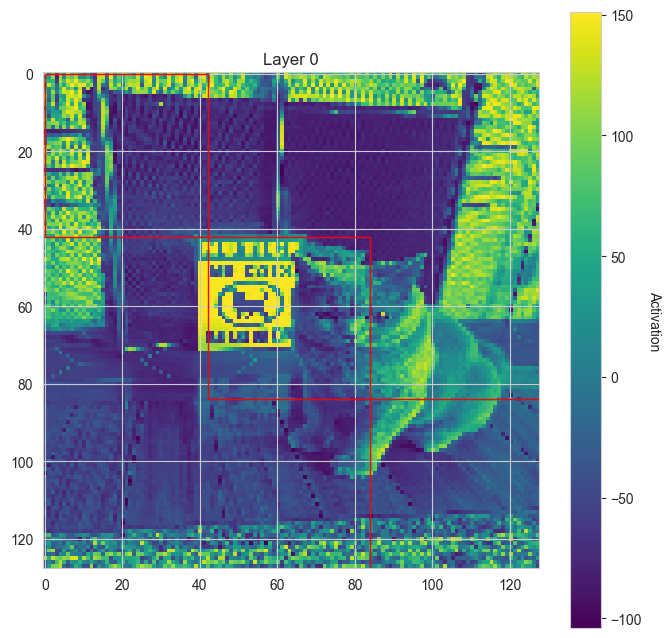

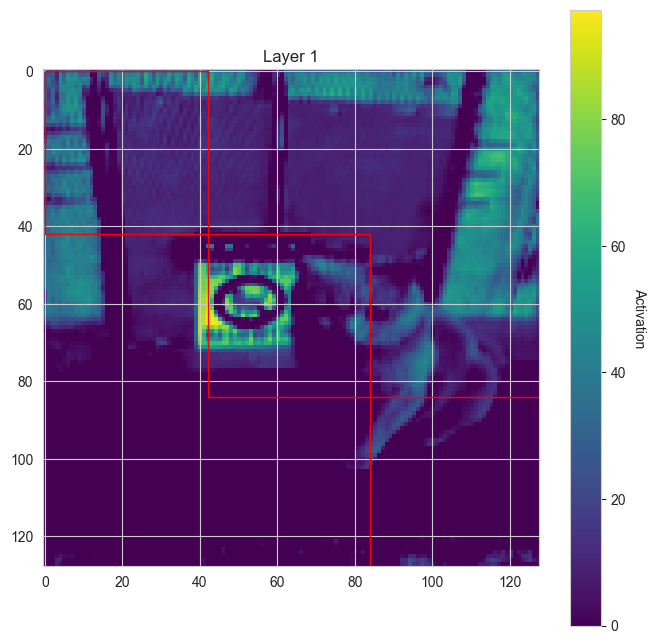

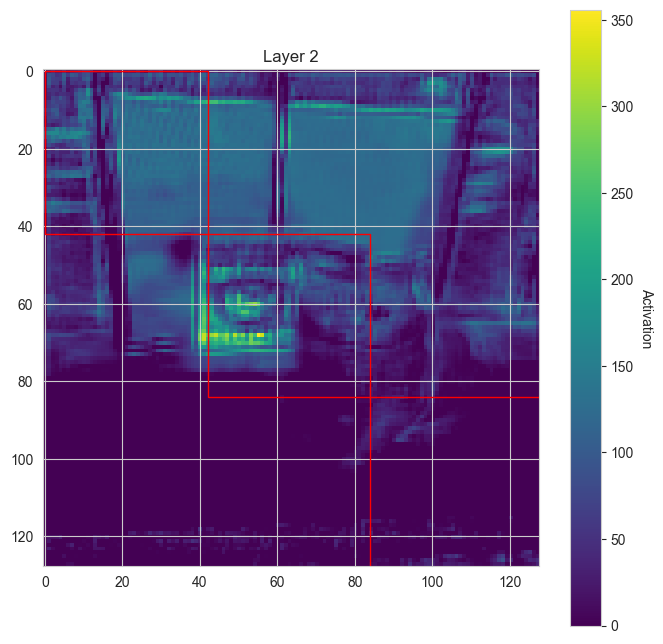

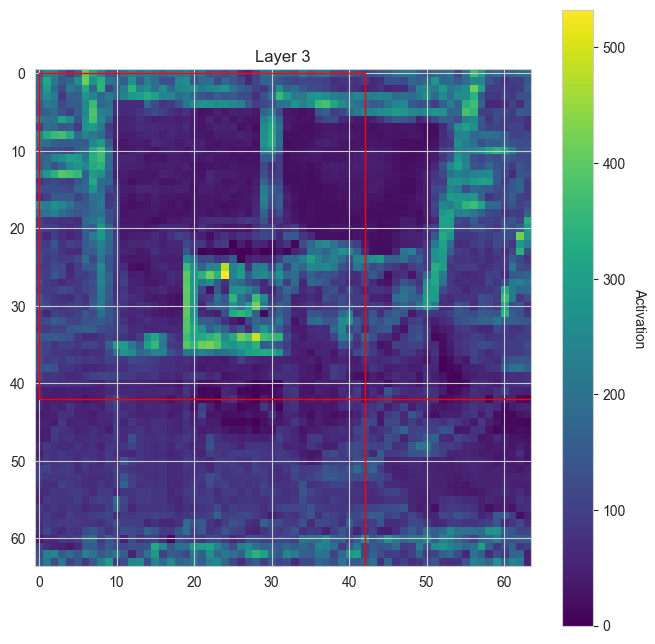

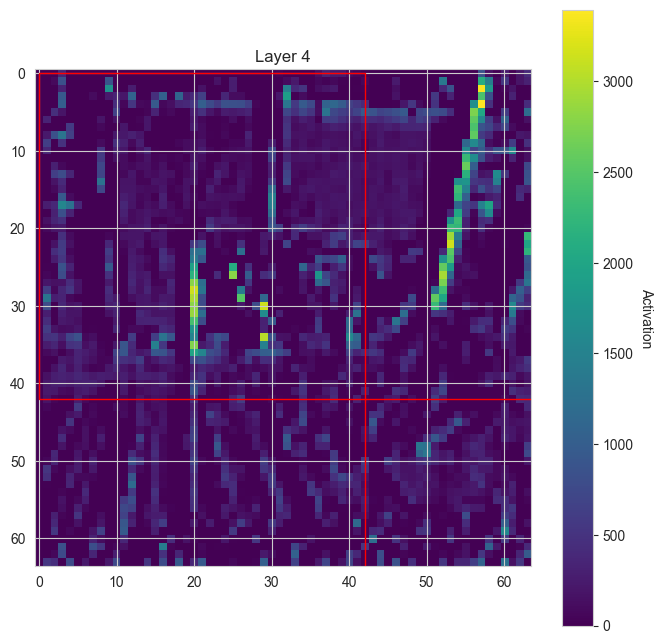

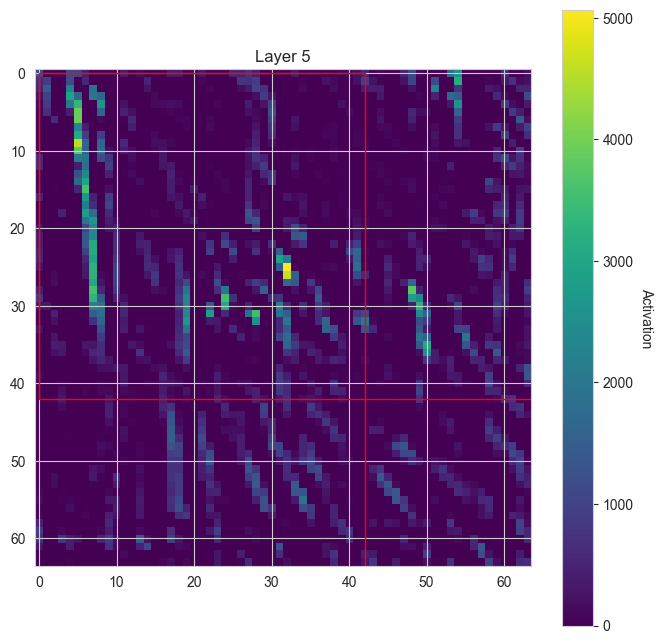

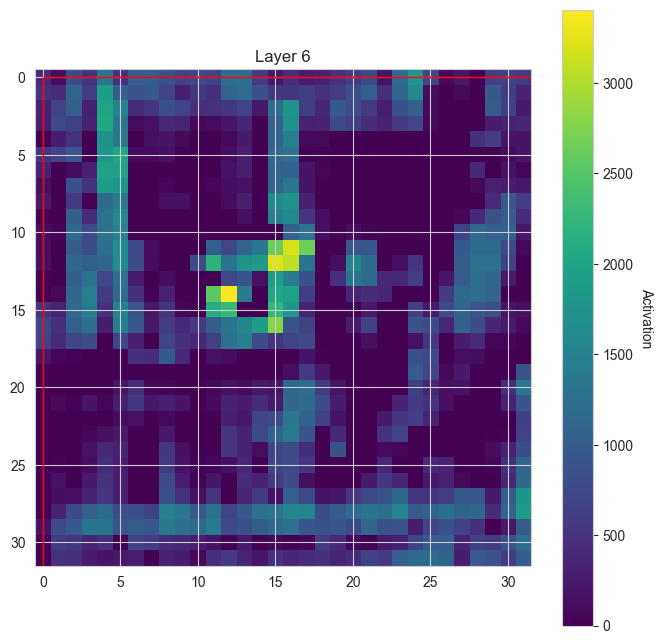

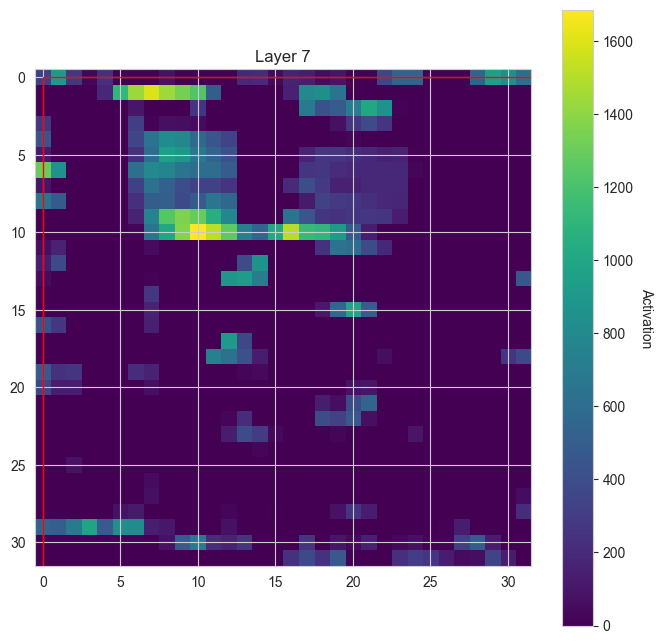

In [12]:
img_path = '/Users/George_1/PycharmProjects/MLFINAL2/90k1incvmdta1.jpeg'
img = image.load_img(img_path, target_size=(128, 128))

# Convert the image to a numpy array and preprocess it
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract the outputs of intermediate layers in the model
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x)

# Define the regions of interest
rois = [(0, 0, 42, 42), (42, 42, 84, 84), (84, 84, 128, 128)]

# Plot the activations for each layer
for i, activation in enumerate(activations):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(activation[0, :, :, i], cmap='viridis')
    plt.title('Layer ' + str(i))
    # Highlight the regions of interest
    for roi in rois:
        rect = plt.Rectangle((roi[0], roi[1]), roi[2] - roi[0], roi[3] - roi[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # Add a color bar legend
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Activation', rotation=-90, va="bottom")
    plt.show()

Horse Image Analysis:

1/1 [==============================] - 0s 200ms/step


2023-04-22 16:46:47.249017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


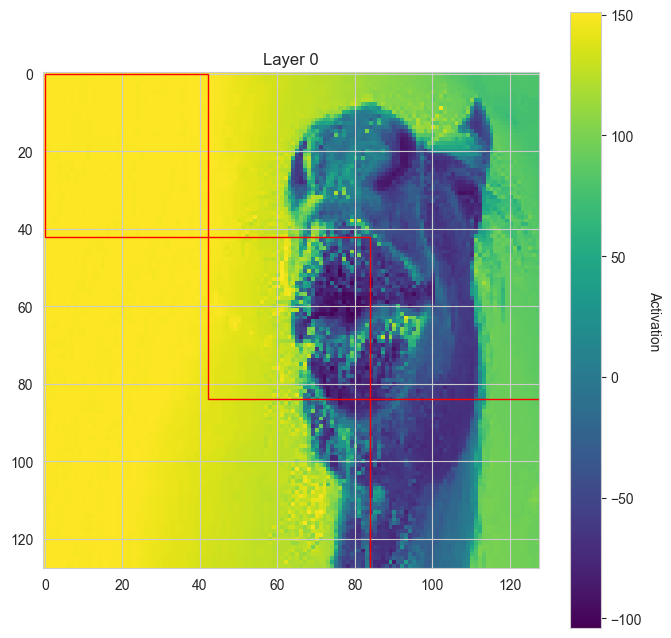

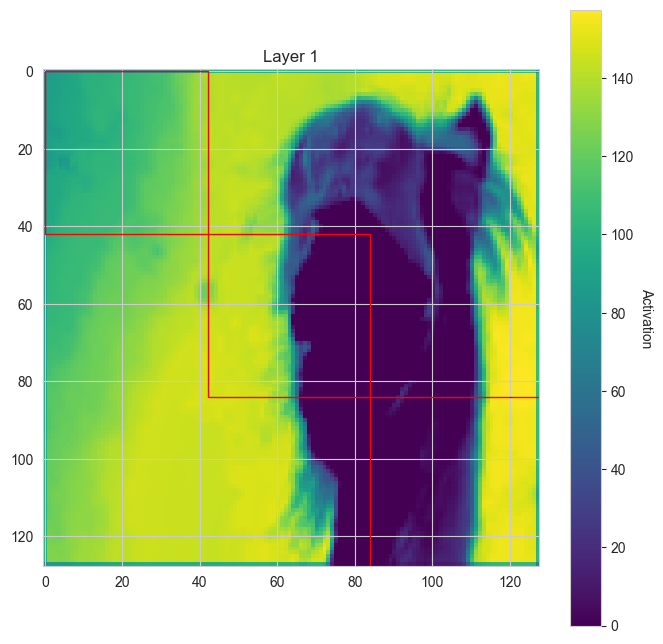

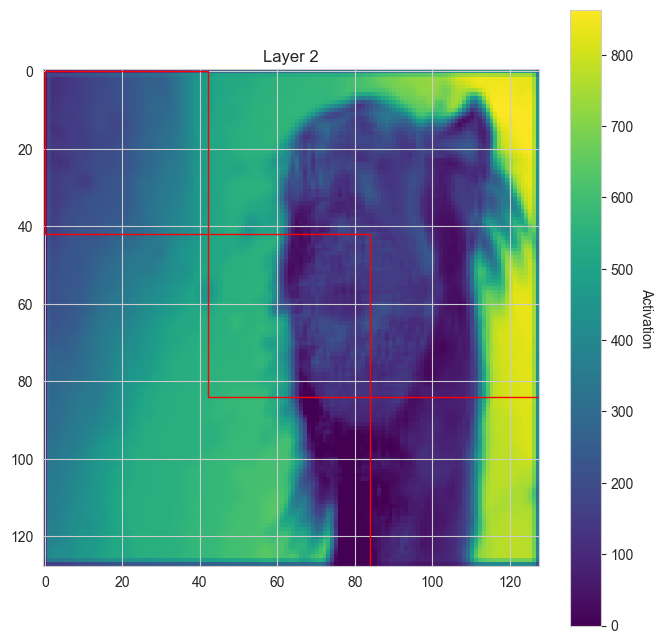

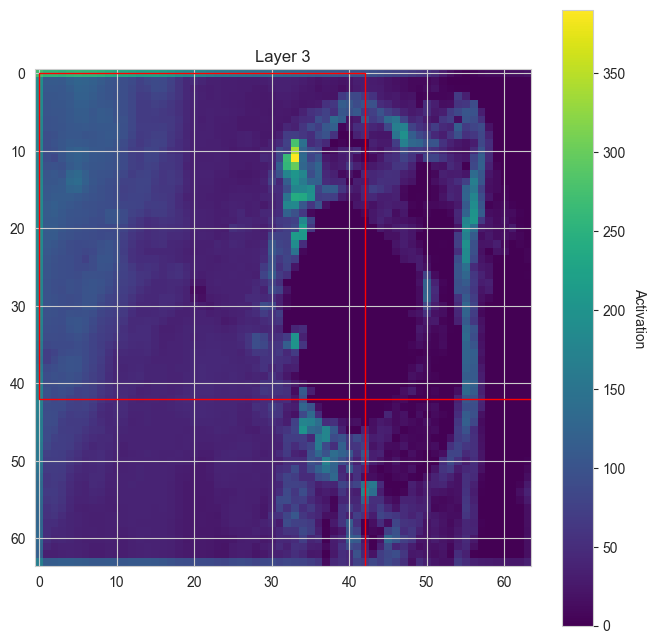

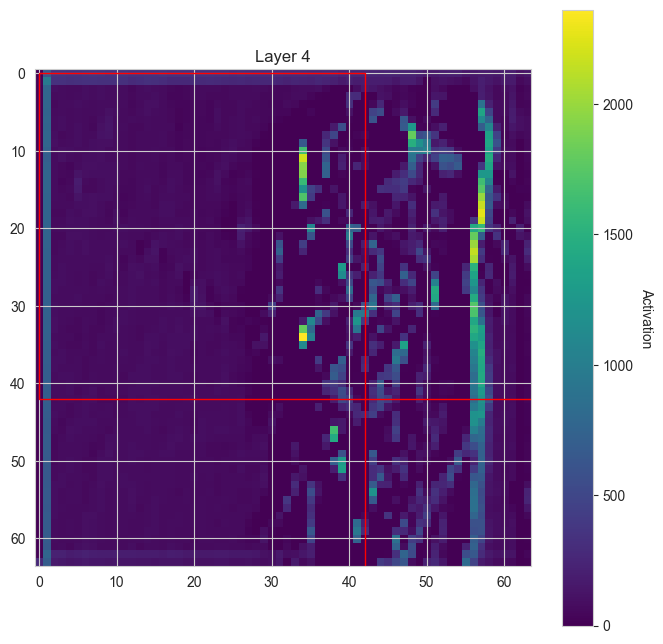

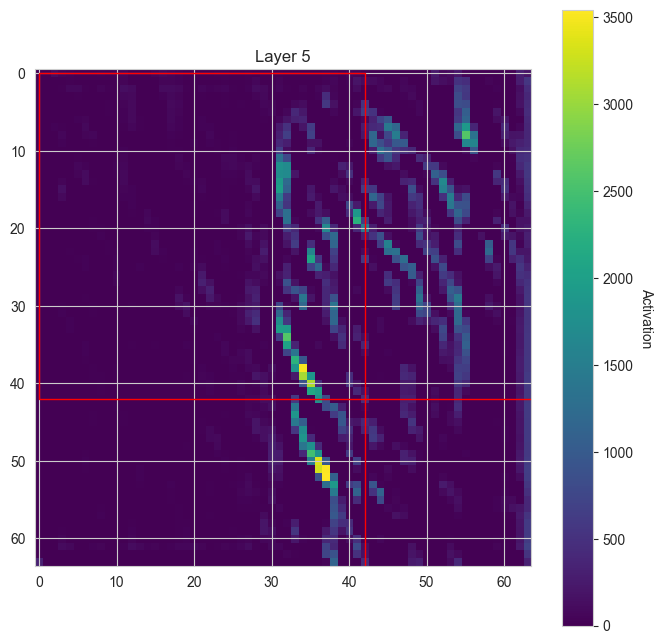

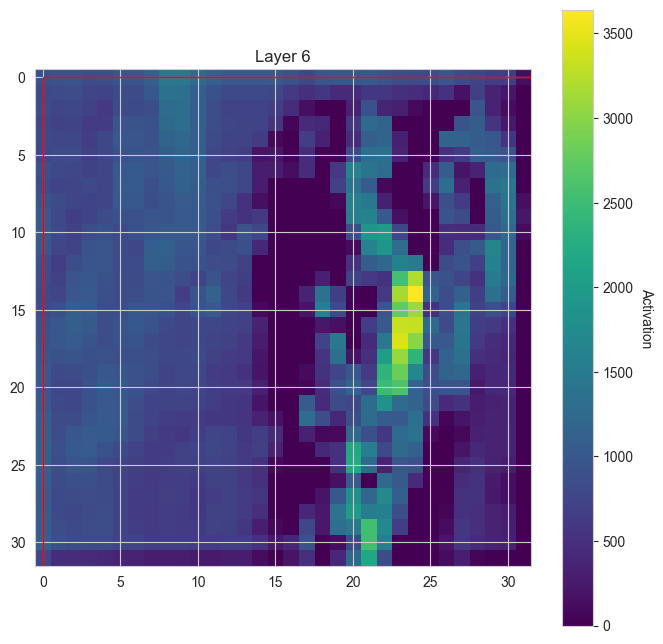

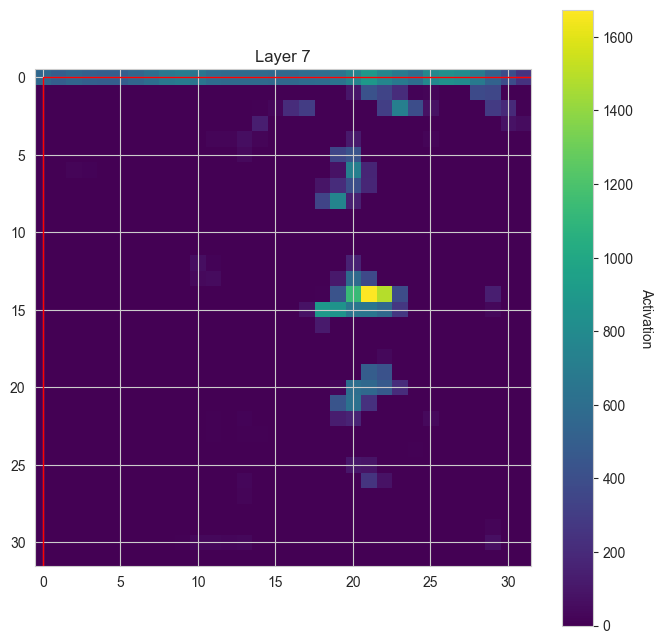

In [13]:
img_path = '/Users/George_1/PycharmProjects/ML3/360_F_295442295_OXsXOmLmqBUfZreTnGo9PREuAPSLQhff.jpg'
img = image.load_img(img_path, target_size=(128, 128))

# Convert the image to a numpy array and preprocess it
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract the outputs of intermediate layers in the model
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x)

# Define the regions of interest
rois = [(0, 0, 42, 42), (42, 42, 84, 84), (84, 84, 128, 128)]

# Plot the activations for each layer
for i, activation in enumerate(activations):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(activation[0, :, :, i], cmap='viridis')
    plt.title('Layer ' + str(i))
    # Highlight the regions of interest
    for roi in rois:
        rect = plt.Rectangle((roi[0], roi[1]), roi[2] - roi[0], roi[3] - roi[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # Add a color bar legend
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Activation', rotation=-90, va="bottom")
    plt.show()

Blue Box Image Analysis:

2023-04-22 16:46:49.185003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 260ms/step


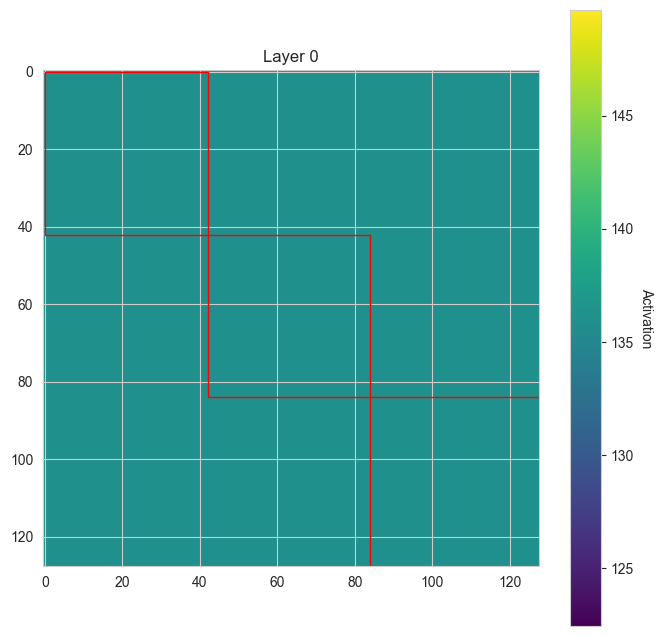

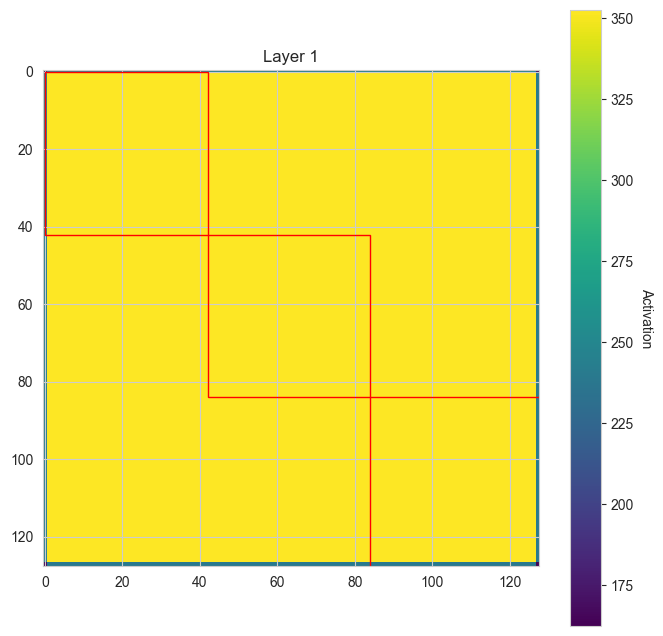

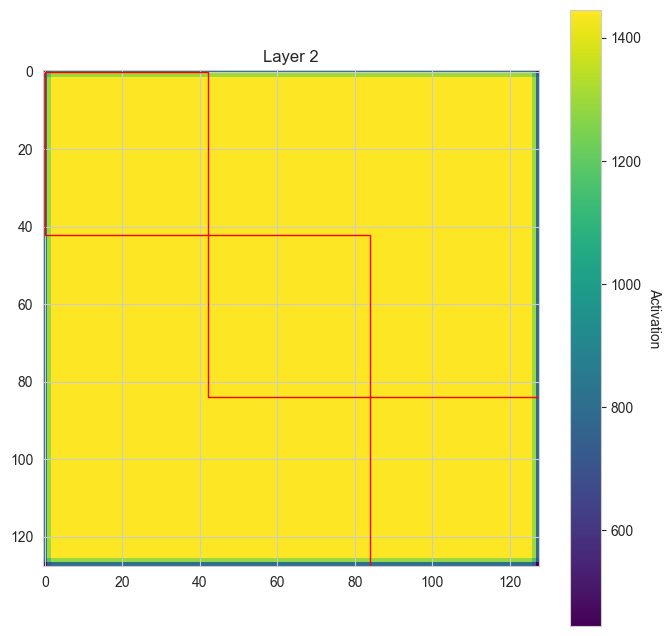

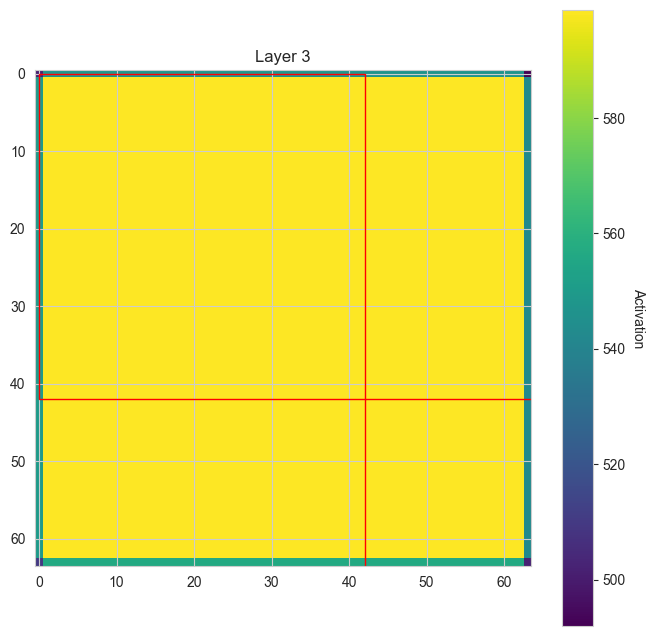

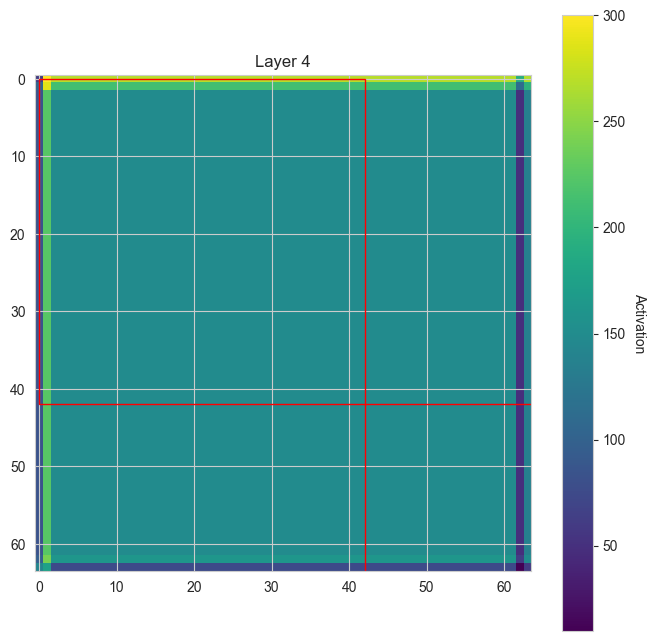

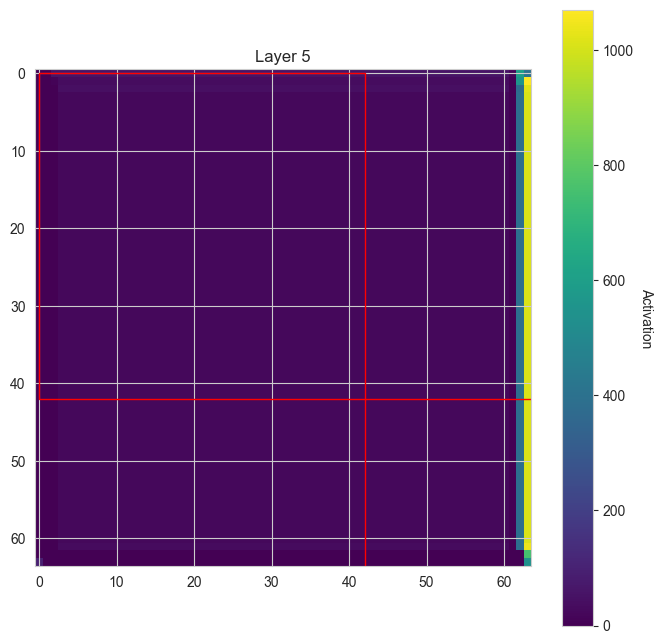

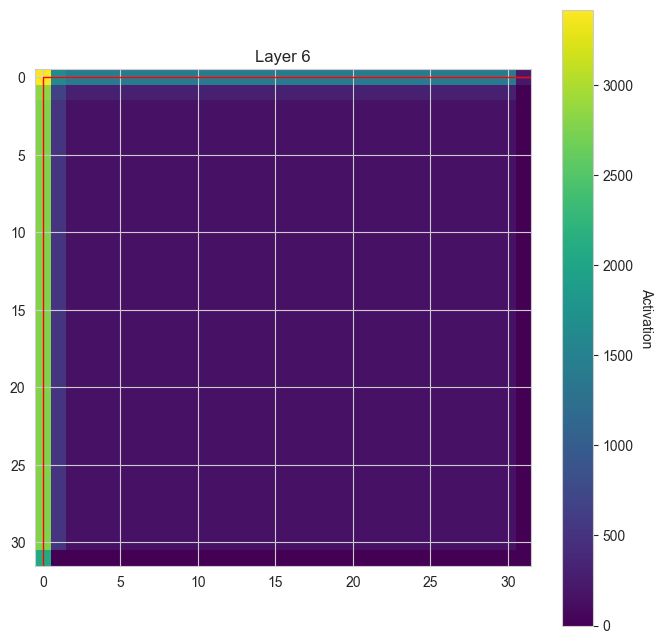

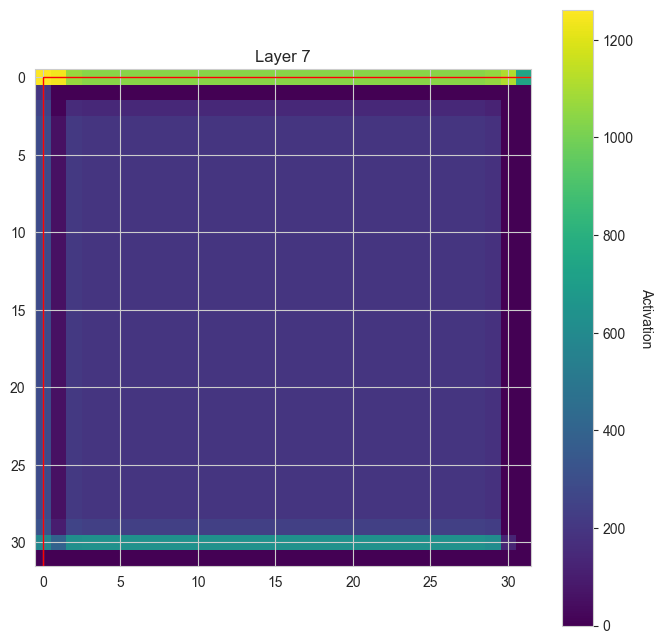

In [14]:
# Load an example image
img_path = '/Users/George_1/PycharmProjects/ML3/blue0517-4dfc85cb0200460ab717b101ac07888f.jpg'
img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x)


rois = [(0, 0, 42, 42), (42, 42, 84, 84), (84, 84, 128, 128)]


for i, activation in enumerate(activations):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(activation[0, :, :, i], cmap='viridis')
    plt.title('Layer ' + str(i))

    for roi in rois:
        rect = plt.Rectangle((roi[0], roi[1]), roi[2] - roi[0], roi[3] - roi[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Activation', rotation=-90, va="bottom")
    plt.show()


Asteíos Image Analysis:

1/1 [==============================] - 0s 200ms/step


2023-04-22 16:46:51.211741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


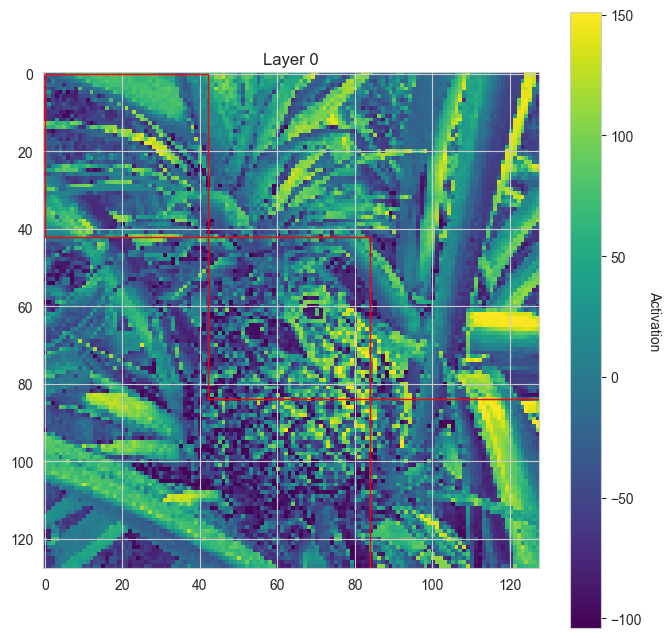

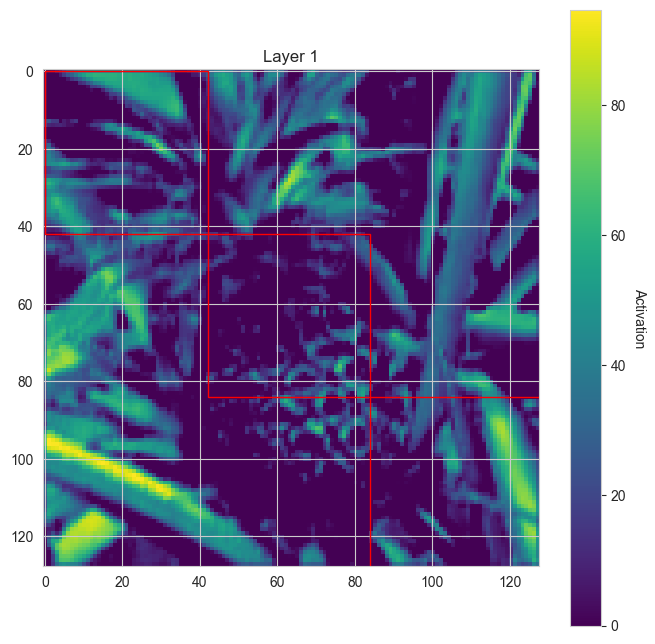

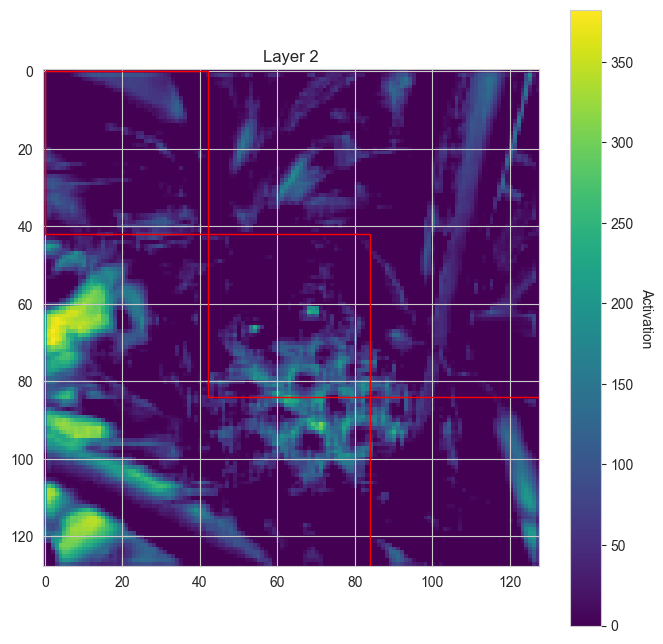

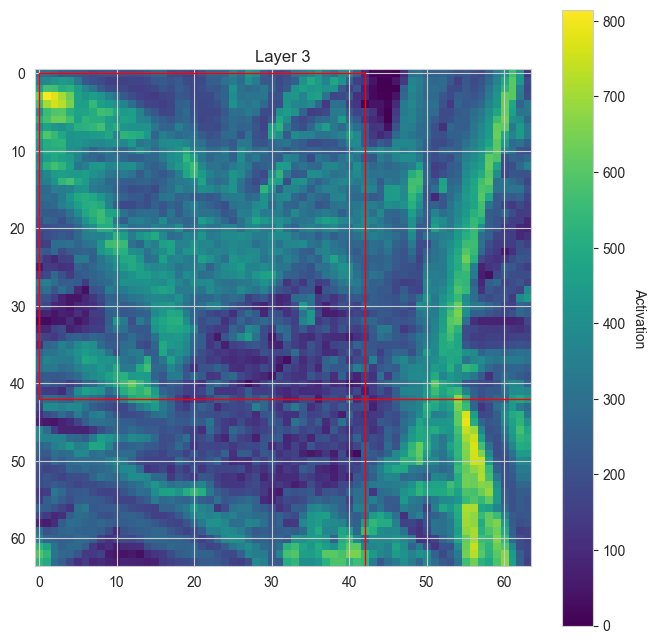

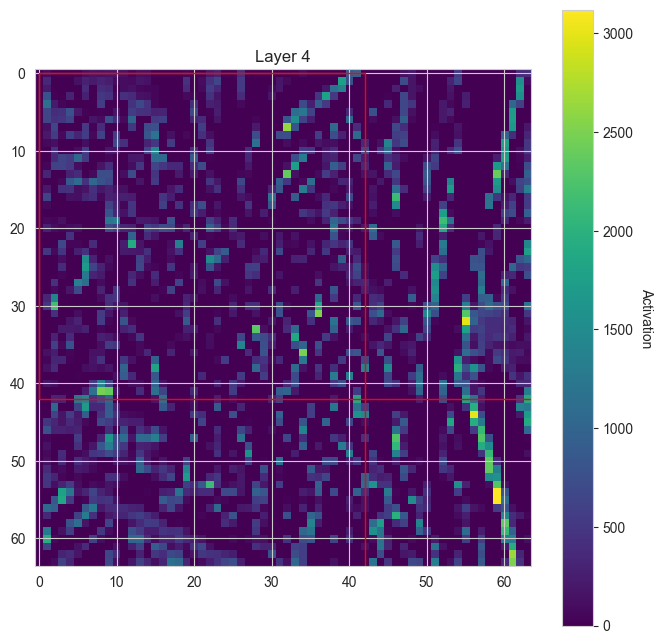

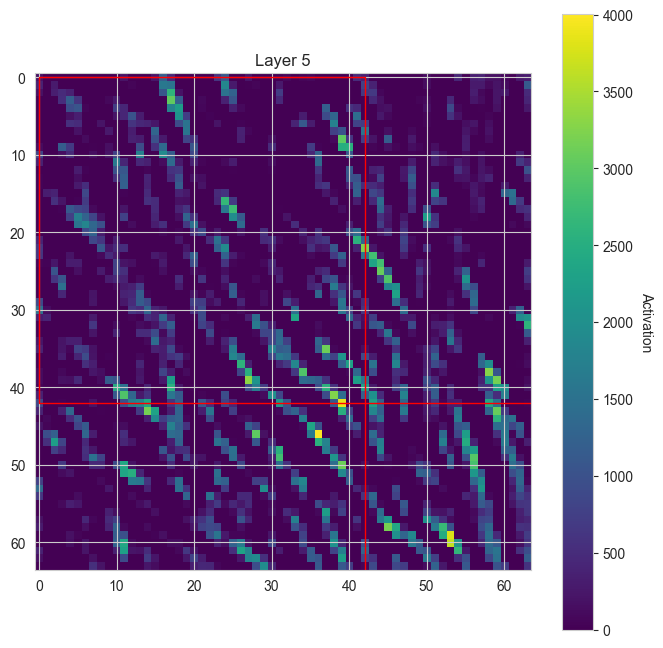

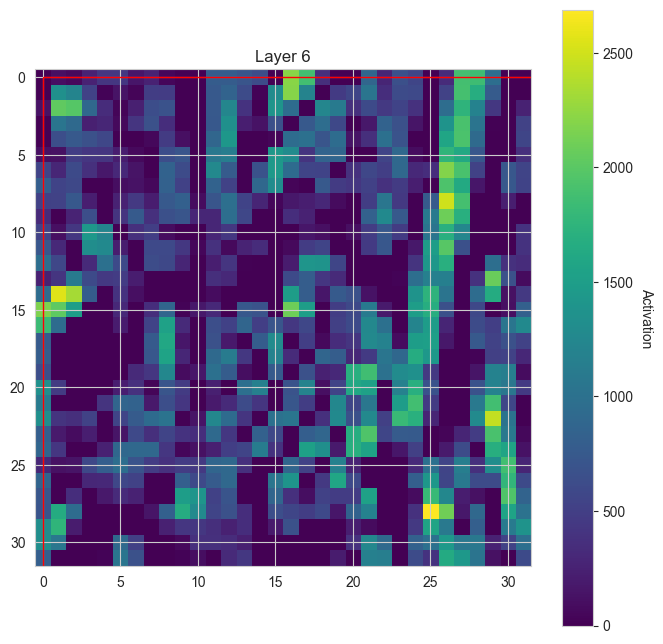

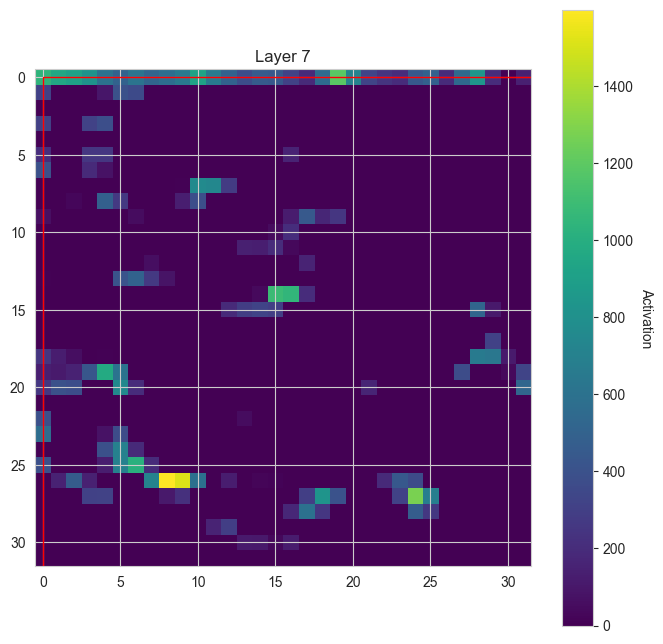

In [15]:
# Load an example image
img_path = '/Users/George_1/PycharmProjects/ML3/dcij90t3mn5a1.jpg'
img = image.load_img(img_path, target_size=(128, 128))


x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x)

# Define the regions of interest
rois = [(0, 0, 42, 42), (42, 42, 84, 84), (84, 84, 128, 128)]


for i, activation in enumerate(activations):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(activation[0, :, :, i], cmap='viridis')
    plt.title('Layer ' + str(i))

    for roi in rois:
        rect = plt.Rectangle((roi[0], roi[1]), roi[2] - roi[0], roi[3] - roi[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Activation', rotation=-90, va="bottom")
    plt.show()


In [ ]:
visualkeras.layered_view(model, legend=True)